# Note

+ Ma khuyen mai duoc su dung nhieu nhat

In [1]:
# from pyspark.sql import functions as f, SparkSession, DataFrame, Window
# from pyspark.sql.functions import col, lit, udf
# from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
import numpy as np
from collections import Counter
import math
from statistics import median
from scipy.stats import skew

warnings.filterwarnings("ignore")
np.set_printoptions(linewidth=1000000)

# pd.options.display.float_format = "{:.0f}".format
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# import cx_Oracle

# def get_data_from_oracledb(
#     server_ip = '10.22.117.200', SID = 'BIGDATA', port = '1521',
#     user_name = 'PTDL_PTKD', password = 'PTDL_PTKD', sql_query = 'select * from EWVNP1.USER_MAP'):
#     # conn1 = cx_Oracle.connect("VHDVTT/VHDVTT@10.22.117.200:1521/BIGDATA") 
#     conn1 = cx_Oracle.connect(user_name+'/'+password+'@'+server_ip+':'+port+'/'+SID) 
#     cursor1= conn1.cursor()
#     cursor1.execute(sql_query)
#     result = cursor1.fetchall()
#     df = pd.DataFrame(result)
#     field_names = [i[0] for i in cursor1.description]
#     df.columns = field_names
#     return df


# Get data

In [ ]:
# # Bang datamart customer
# query = '''
#     select USER_MAP_ID, TXN_ID, TXN_TYPE, TRANS_TIME, STATUS, TXN_AMOUNT, REAL_AMOUNT, PROMO_AMOUNT, DISCOUNT_AMOUNT, FEE_AMOUNT
#     from DWH_EWVNP.T_FT_TXN_DAILY
#     where SOURCE = 'VAS_TXN'
# '''
# vastxn = get_data_from_oracledb(
#                 sql_query = query, 
#                 server_ip= '10.22.129.11',
#                 SID = 'DWHVNPAY',
#                 user_name='vhdvtt',
#                 password='Vnpay@2022)(*&')

In [35]:
vastxn = pd.read_csv('data\\vastxn.csv')

In [36]:
cus = pd.read_csv('data\\DIM_CUS2.csv')

In [37]:
# Phan loai GD thanh cong va khong thanh cong
vastxn['SUCCESS_STATUS'] = 0
vastxn.loc[ (vastxn['STATUS'] == 'V2') & (vastxn['STATUS'] == 'V22'), 'SUCCESS_STATUS' ] = 1
vastxn.loc[ (vastxn['STATUS'] == 'V4') & (vastxn['STATUS'] != 'V22'), 'SUCCESS_STATUS' ] = 1


In [38]:
# Lấy tháng năm giao dịch 
vastxn['TRANS_YEAR_MONTH'] = vastxn['TRANS_TIME'].str.slice(0,7)

In [39]:
# convert datetime col
vastxn['TRANS_TIME'] = pd.to_datetime( vastxn['TRANS_TIME'])

In [40]:
# lấy ngày giao dịch
vastxn['TRANS_DATE'] = vastxn['TRANS_TIME'].dt.date
vastxn['TRANS_HOUR'] = vastxn['TRANS_TIME'].dt.hour



In [41]:
# Lay ngay cuoi tuan va trong tuan:
vastxn['TRANS_WEEKDAY'] = vastxn['TRANS_TIME'].dt.weekday
vastxn.loc[vastxn['TRANS_WEEKDAY'] < 5, 'IS_WEEKDAY'] = 1
vastxn.loc[vastxn['TRANS_WEEKDAY'] > 4, 'IS_WEEKEND'] = 1


In [42]:
# Phân loại giao dịch có sử dụng mã khuyến mãi hay không:
vastxn.loc[vastxn['PROMO_AMOUNT'] > 0, 'IS_USINGVOUCHER'] = 1


In [44]:
vastxn.TRANS_DATE.min(), vastxn.TRANS_DATE.max()

(datetime.date(2020, 3, 12), datetime.date(2022, 10, 9))

In [45]:
vastxn.shape

(6161767, 18)

In [ ]:
# set age group:
cus.loc[cus['AGE_LEVEL'] < 15, 'AGE_GROUP'] = 'Khong XD'
cus.loc[(cus['AGE_LEVEL'] >= 15) & (cus['AGE_LEVEL'] < 18), 'AGE_GROUP'] = '15-18'
cus.loc[(cus['AGE_LEVEL'] >= 18) & (cus['AGE_LEVEL'] < 25), 'AGE_GROUP'] = '18-25'
cus.loc[(cus['AGE_LEVEL'] >= 25) & (cus['AGE_LEVEL'] < 35), 'AGE_GROUP'] = '25-35'
cus.loc[(cus['AGE_LEVEL'] >= 35) & (cus['AGE_LEVEL'] < 45), 'AGE_GROUP'] = '35-45'
cus.loc[(cus['AGE_LEVEL'] >= 45) & (cus['AGE_LEVEL'] < 55), 'AGE_GROUP'] = '45-55'
cus.loc[(cus['AGE_LEVEL'] >= 55) & (cus['AGE_LEVEL'] < 65), 'AGE_GROUP'] = '55-65'
cus.loc[cus['AGE_LEVEL'] >= 65, 'AGE_GROUP'] = 'Khong XD'


In [ ]:
# Join thong tin khacsh hang voi bang vastxn:
vastxn = pd.merge(
    left = vastxn,
    right = cus[['MAP_ID', 'CIF_GENDER', 'OS', 'USER_CREATED_DATE', 'AGE_GROUP']],
    left_on = 'USER_MAP_ID',
    right_on= 'MAP_ID',
    how = 'left'
)
vastxn['USER_CREATED_DATE'] = pd.to_datetime( vastxn['USER_CREATED_DATE'])


In [ ]:
# Tao them 3 truong REAL_AMOUNT de ting min, max, avg, sum:
vastxn['REAL_AMOUNT2'] = vastxn['REAL_AMOUNT']
vastxn['REAL_AMOUNT3'] = vastxn['REAL_AMOUNT']
vastxn['REAL_AMOUNT4'] = vastxn['REAL_AMOUNT']


# EDA

In [ ]:
# Lay ban ghi GD thanh cong
sucTrans = vastxn[vastxn['SUCCESS_STATUS'] == 1]


In [ ]:
# Pivot khach hang de lay thong tin giao dich qua cac thang
cusTransPivot = pd.pivot_table(
    data = sucTrans,
    index= 'USER_MAP_ID',
    columns= 'TRANS_YEAR_MONTH',
    values= 'TXN_ID',
    aggfunc= np.count_nonzero
).reset_index()

In [ ]:
cusTransPivot.head()

TRANS_YEAR_MONTH,USER_MAP_ID,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
0,555301097124929536,NaN,NaN,5.0,16.0,5.0,8.0,20.0,13.0,18.0,10.0,5.0,5.0,13.0,18.0,17.0,17.0,18.0,6.0,9.0,12.0,13.0,22.0,14.0,15.0,25.0,26.0,23.0,21.0,28.0,18.0,26.0,10.0
1,555308165009514496,21.0,4.0,14.0,7.0,2.0,13.0,5.0,6.0,6.0,14.0,18.0,9.0,23.0,13.0,2.0,2.0,4.0,NaN,4.0,4.0,NaN,1.0,5.0,6.0,8.0,11.0,14.0,17.0,21.0,20.0,15.0,6.0
2,555339471202295808,5.0,1.0,5.0,1.0,4.0,NaN,1.0,9.0,13.0,15.0,7.0,16.0,7.0,9.0,7.0,5.0,10.0,12.0,4.0,5.0,14.0,6.0,5.0,11.0,4.0,17.0,18.0,18.0,17.0,16.0,18.0,4.0
3,555342520264171520,7.0,2.0,15.0,7.0,3.0,13.0,6.0,10.0,5.0,8.0,14.0,9.0,17.0,9.0,9.0,2.0,6.0,6.0,6.0,9.0,10.0,7.0,9.0,14.0,11.0,11.0,23.0,17.0,26.0,20.0,24.0,10.0
4,555343621206056960,19.0,6.0,8.0,3.0,4.0,7.0,4.0,6.0,7.0,8.0,27.0,18.0,26.0,27.0,19.0,16.0,17.0,7.0,5.0,22.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Extract features

## Sample 1 tháng

In [ ]:
# # lấy sample 1 tháng
# currMonth = '2022-06'
# vastxn1 = vastxn[vastxn['TRANS_YEAR_MONTH'] == currMonth]
# # ngày gd cuối cùng của tháng
# last_trans_date = vastxn1['TRANS_TIME'].max()
# # GD thành công
# suc_trans1 = vastxn1[vastxn1['SUCCESS_STATUS'] == 1]

In [ ]:
# # Features group 1:
# feat1 = suc_trans1.groupby('USER_MAP_ID').agg({
#     # Trans amount min:
#     'REAL_AMOUNT': 'min',
#     # Trans amount max:
#     'REAL_AMOUNT2': 'max',
#     # Trans amount mean:
#     'REAL_AMOUNT3': 'mean',
#     # Trans amount total:
#     'REAL_AMOUNT4': 'sum',
#     # f_user_daysSinceLastTransc:
#     'TRANS_TIME': lambda cus_trans_date: (last_trans_date - cus_trans_date.max()).days,
#     # f_user_transcCurrMonth_count:
#     'TXN_ID': 'count',
#     # Number of promotion transaction count:
#     'IS_USINGVOUCHER': 'count',
#     # f_transcByDayOfMonth_ratio:
#     'TRANS_DATE': lambda transDate: transDate.nunique() / last_trans_date.days_in_month,
#     # Total trans on weekday:
#     'IS_WEEKDAY': 'sum',
#     # Total trans on weekend:
#     'IS_WEEKEND': 'sum',
#     # Total promotion amount:
#     'PROMO_AMOUNT': 'sum',
#     # Customer age group:
#     'AGE_GROUP': lambda ageGroup: ageGroup.unique()[0],
#     # Customer gender:
#     'CIF_GENDER': lambda gender: gender.unique()[0],
#     # device's os:
#     'OS': lambda os: os.unique()[0],
#     # Number Days since joined:
#     'USER_CREATED_DATE': lambda userCreatedDate: (last_trans_date - userCreatedDate.min()).days
# }).reset_index()

# # Rename columns:
# feat1.columns = ['USER_MAP_ID', 'transAmountMin', 'transAmountMax', 'transAmountAvg', 'transAmountTotal',\
#      'daysSinceLastTrans', 'transCurrMonth_Count', 'transPromotion_Count', 'transByDayOfMonth_ratio',\
#     'transWeekday_count', 'transWeekEnd_count', 'transPromotionAmount', 'ageGroup', 'gender', 'os', 'daySinceJoined']
# # Tỉ lệ sử dụng giao dịch mã khuyến mãi trên tổng số giao dịch:
# feat1['transUsingPromotion_Ratio'] = feat1['transPromotion_Count'] / feat1['transCurrMonth_Count']

In [ ]:
# # Function lay thong tin so lan giao dich trong thang tiep theo:
# def getNextMonth(currMonth):
#     '''
#     Function input with format yyyy-mm and get the output is the next year-month
#     '''
#     month = int(currMonth[-2:])
#     year = int(currMonth[:4])
#     if month <= 8:
#         nextMonth = currMonth[:-1] + str(month + 1)
#     elif (month >= 9) and (month < 12):
#         nextMonth = currMonth[:-2] + str(month + 1)
#     elif month == 12:
#         nextMonth = str(year + 1) + '-01'
#     return nextMonth

# nextMonth = getNextMonth(currMonth)


In [ ]:
# # get all customers has made transaction in next month:
# cusNextMonth = cusTransPivot[~cusTransPivot[nextMonth].isna()][['USER_MAP_ID', nextMonth]]
# # mapping với bảng cusFeatureCurrMonth để lấy slgd của nextMonth:
# feat1 = pd.merge(
#     left = feat1,
#     right = cusNextMonth,
#     on = 'USER_MAP_ID',
#     how = 'left'
# )
# # Rename columns
# feat1.rename(columns={nextMonth: 'isTransNextMonth'}, inplace=True)
# # Fill những khách hàng k giao dịch trong tháng tiêp theo là 0:
# feat1['isTransNextMonth'].fillna(0, inplace=True)



In [ ]:
# Put into a function to calculate features of each year-month:
# Function lay thong tin thang tiep theo:
def getNextMonth(currMonth):
    '''
    Function input with format yyyy-mm and get the output is the next year-month
    '''
    month = int(currMonth[-2:])
    year = int(currMonth[:4])
    if month <= 8:
        nextMonth = currMonth[:-1] + str(month + 1)
    elif (month >= 9) and (month < 12):
        nextMonth = currMonth[:-2] + str(month + 1)
    elif month == 12:
        nextMonth = str(year + 1) + '-01'
    return nextMonth

# Function lay thong tin thang truoc:
def getPrevMonth(currMonth):
    '''
    Function input with format yyyy-mm and get the output is the prev year-month
    '''
    month = int(currMonth[-2:])
    year = int(currMonth[:4])
    if month == 1:
        prevMonth = str(year - 1) + '-12'
    elif (month >= 11) and (month <= 12):
        prevMonth = currMonth[:-2] + str(month - 1 )
    else:
        prevMonth = str(year) + '-0' + str(month - 1 )
    return prevMonth


def calculateFeaturesYearMonth(currMonth, nextMonth, prevMonth, sucTransCurrMonth, cusTransPivot):
    # ngày gd cuối cùng của tháng
    last_trans_date = sucTransCurrMonth['TRANS_TIME'].max()

    # Features group 1:
    feat1 = sucTransCurrMonth.groupby('USER_MAP_ID').agg({
        # Trans amount min:
        'REAL_AMOUNT': 'min',
        # Trans amount max:
        'REAL_AMOUNT2': 'max',
        # Trans amount mean:
        'REAL_AMOUNT3': 'mean',
        # Trans amount total:
        'REAL_AMOUNT4': 'sum',
        # f_user_daysSinceLastTransc:
        'TRANS_TIME': lambda cus_trans_date: (last_trans_date - cus_trans_date.max()).days,
        # f_user_transcCurrMonth_count:
        'TXN_ID': 'count',
        # Number of promotion transaction count:
        'IS_USINGVOUCHER': 'count',
        # f_transcByDayOfMonth_ratio:
        'TRANS_DATE': lambda transDate: transDate.nunique() / last_trans_date.days_in_month,
        # Total trans on weekday:
        'IS_WEEKDAY': 'sum',
        # Total trans on weekend:
        'IS_WEEKEND': 'sum',
        # Total promotion amount:
        'PROMO_AMOUNT': 'sum',
        # Customer age group:
        'AGE_GROUP': lambda ageGroup: ageGroup.unique()[0],
        # Customer gender:
        'CIF_GENDER': lambda gender: gender.unique()[0],
        # device's os:
        'OS': lambda os: os.unique()[0],
        # Number Days since joined:
        'USER_CREATED_DATE': lambda userCreatedDate: (last_trans_date - userCreatedDate.min()).days
    }).reset_index()

    # Rename columns:
    feat1.columns = ['USER_MAP_ID', 'transAmountMin', 'transAmountMax', 'transAmountAvg', 'transAmountTotal',\
        'daysSinceLastTrans', 'transCurrMonth_Count', 'transPromotion_Count', 'transByDayOfMonth_ratio',\
        'transWeekday_count', 'transWeekEnd_count', 'transPromotionAmount', 'ageGroup', 'gender', 'os', 'daySinceJoined']
    # Tỉ lệ sử dụng giao dịch mã khuyến mãi trên tổng số giao dịch:
    feat1['transUsingPromotion_Ratio'] = feat1['transPromotion_Count'] / feat1['transCurrMonth_Count']

    # ===============================================================================
    # Trường hợp muốn viết thêm feature thì viết vào đây, sau đó merge với bảng feat1
    # ===============================================================================

    # get all customers has made transaction in next month:
    cusNextMonth = cusTransPivot[~cusTransPivot[nextMonth].isna()][['USER_MAP_ID', nextMonth]]
    # mapping với bảng cusFeatureCurrMonth để lấy slgd của nextMonth:
    feat1 = pd.merge(
        left = feat1,
        right = cusNextMonth,
        on = 'USER_MAP_ID',
        how = 'left'
    )
    # Rename columns
    feat1.rename(columns={nextMonth: 'isTransNextMonth'}, inplace=True)
    # Fill những khách hàng k giao dịch trong tháng tiêp theo là 0:
    feat1['isTransNextMonth'].fillna(0, inplace=True)

    # Get all customer and their trans number in the prev month
    try:
        cusPrevMonth = cusTransPivot[~cusTransPivot[prevMonth].isna()][['USER_MAP_ID', prevMonth]]
        feat1 = pd.merge(
                    left = feat1,
                    right = cusPrevMonth,
                    on = 'USER_MAP_ID',
                    how = 'left'
                )
        # Rename columns
        feat1.rename(columns={prevMonth: 'transPrevMonth_Count'}, inplace=True)
        feat1['transPrevMonth_Count'].fillna(0, inplace=True)
    except: # incase we don't have the prev month:
        feat1['transPrevMonth_Count'] = 0

    return feat1


## Perform on all dataset

In [ ]:
# Get all yearmonth:
tranYearMonths = vastxn.sort_values(['TRANS_TIME'], ascending=True)['TRANS_YEAR_MONTH'].unique()

# Loop into each month and calculate features:
totalCusFeatures = []
for currMonth in tranYearMonths:
    sucTransCurrMonth = sucTrans[sucTrans['TRANS_YEAR_MONTH'] == currMonth]
    nextMonth = getNextMonth(currMonth=currMonth)
    prevMonth = getPrevMonth(currMonth=currMonth)
    # Khi currMonth la thang cuoi cung trong du lieu thi khong chay nua
    if currMonth == tranYearMonths[-1]: 
        break
    else:
        cusFeaturesYearMonth = calculateFeaturesYearMonth(
                                        currMonth=currMonth,
                                        nextMonth=nextMonth,
                                        prevMonth=prevMonth,
                                        sucTransCurrMonth=sucTransCurrMonth,
                                        cusTransPivot=cusTransPivot)
        totalCusFeatures.append(cusFeaturesYearMonth)
    
# Concat all features into 1 dataframe:
cusFeatures = pd.concat(totalCusFeatures, axis = 0)


In [ ]:
# Get all yearmonth:
tranYearMonths = vastxn.sort_values(['TRANS_TIME'], ascending=True)['TRANS_YEAR_MONTH'].unique()

# Loop into each month and calculate features:
totalCusFeatures = []
for currMonth in tranYearMonths:
    sucTransCurrMonth = sucTrans[sucTrans['TRANS_YEAR_MONTH'] == currMonth]
    nextMonth = getNextMonth(currMonth=currMonth)
    prevMonth = getPrevMonth(currMonth=currMonth)
    # Khi currMonth la thang cuoi cung trong du lieu thi khong chay nua
    if currMonth == tranYearMonths[-1]: 
        break
    else:
        cusFeaturesYearMonth = calculateFeaturesYearMonth(
                                        currMonth=currMonth,
                                        nextMonth=nextMonth,
                                        prevMonth=prevMonth,
                                        sucTransCurrMonth=sucTransCurrMonth,
                                        cusTransPivot=cusTransPivot)
        totalCusFeatures.append(cusFeaturesYearMonth)
    if currMonth == '2020-04':
        break
# Concat all features into 1 dataframe:
cusFeatures_temp = pd.concat(totalCusFeatures, axis = 0)


In [ ]:
cusFeatures.shape

(2026137, 19)

In [ ]:
cusFeatures.sample(5)

,USER_MAP_ID,transAmountMin,transAmountMax,transAmountAvg,transAmountTotal,daysSinceLastTrans,transCurrMonth_Count,transPromotion_Count,transByDayOfMonth_ratio,transWeekday_count,transWeekEnd_count,transPromotionAmount,ageGroup,gender,os,daySinceJoined,transUsingPromotion_Ratio,isTransNextMonth,transPrevMonth_Count
37136,776783227485962240,10000,188626,7.845114e+04,549158,11,7,6,0.166667,5.0,2.0,160000,55-65,0,Android,168,0.857143,0.0,2.0
27996,750237971609305088,30000,30000,3.000000e+04,30000,29,1,0,0.033333,1.0,0.0,0,18-25,1,KHONG XD,29,0.000000,0.0,0.0
179820,857479844471521280,10000,10000,1.000000e+04,10000,5,1,0,0.033333,0.0,1.0,0,18-25,1,iOS,6,0.000000,0.0,0.0
146828,875688309715124224,50000,50000,5.000000e+04,50000,17,1,0,0.032258,0.0,1.0,0,25-35,1,Android,18,0.000000,0.0,0.0
10491,698457527926931456,85000,3114000,1.216333e+06,3649000,22,3,2,0.066667,3.0,0.0,146000,25-35,1,Android,172,0.666667,0.0,1.0


# Save file

In [ ]:
# Saving file:
# cusFeatures.to_csv('totalCustomerFeatures.csv', index=False)


# Load features dataset

In [ ]:
cusFeatures = pd.read_csv('totalCustomerFeatures.csv')

In [33]:
cusFeatures.sample(5)

,transAmountMin,transAmountMax,transAmountAvg,transAmountTotal,daysSinceLastTrans,transCurrMonth_Count,transPromotion_Count,transByDayOfMonth_ratio,transWeekday_count,transWeekEnd_count,transPromotionAmount,ageGroup,daySinceJoined,transUsingPromotion_Ratio,isTransNextMonth,transPrevMonth_Count,gender_1,gender_2,os_Android,os_KHONG XD,os_iOS
1647074,225575,225575.0,225575.0,225575,15,1,0.0,0.032258,1.0,0.0,0,2,290.0,0.0,1.0,1.0,1,0,0,0,1
1554041,437500,735000.0,735000.0,735000,23,1,1.0,0.032258,1.0,0.0,35000,3,67.0,1.0,1.0,0.0,0,0,0,0,1
626264,10000,10000.0,10000.0,10000,20,1,0.0,0.032258,1.0,0.0,0,1,20.0,0.0,0.0,0.0,0,0,0,0,1
42383,200000,200000.0,200000.0,200000,6,1,0.0,0.033333,1.0,0.0,0,5,67.0,0.0,1.0,0.0,0,0,0,0,1
1239438,10000,10000.0,10000.0,10000,11,1,0.0,0.032258,1.0,0.0,0,2,12.0,0.0,0.0,0.0,0,0,1,0,0


In [34]:
cusFeatures.columns

Index(['transAmountMin', 'transAmountMax', 'transAmountAvg',
       'transAmountTotal', 'daysSinceLastTrans', 'transCurrMonth_Count',
       'transPromotion_Count', 'transByDayOfMonth_ratio', 'transWeekday_count',
       'transWeekEnd_count', 'transPromotionAmount', 'ageGroup',
       'daySinceJoined', 'transUsingPromotion_Ratio', 'isTransNextMonth',
       'transPrevMonth_Count', 'gender_1', 'gender_2', 'os_Android',
       'os_KHONG XD', 'os_iOS'],
      dtype='object')

In [ ]:
# Chuyển trường isTransNextMonth thành 1 là có giao dịch, 0 là không giao dịch:
cusFeatures.loc[cusFeatures['isTransNextMonth'] > 0, 'isTransNextMonth'] = 1
cusFeatures.loc[cusFeatures['isTransNextMonth'] == 0, 'isTransNextMonth'] = 0


In [ ]:
cusFeatures.isTransNextMonth.value_counts()

0.0    1258676
1.0     767461
Name: isTransNextMonth, dtype: int64

# Preprocessing data

In [ ]:
cusFeatures.describe().columns

Index(['USER_MAP_ID', 'transAmountMin', 'transAmountMax', 'transAmountAvg',
       'transAmountTotal', 'daysSinceLastTrans', 'transCurrMonth_Count',
       'transPromotion_Count', 'transByDayOfMonth_ratio', 'transWeekday_count',
       'transWeekEnd_count', 'transPromotionAmount', 'gender',
       'daySinceJoined', 'transUsingPromotion_Ratio', 'isTransNextMonth',
       'transPrevMonth_Count'],
      dtype='object')

## Numberous columns

### Remove outliers

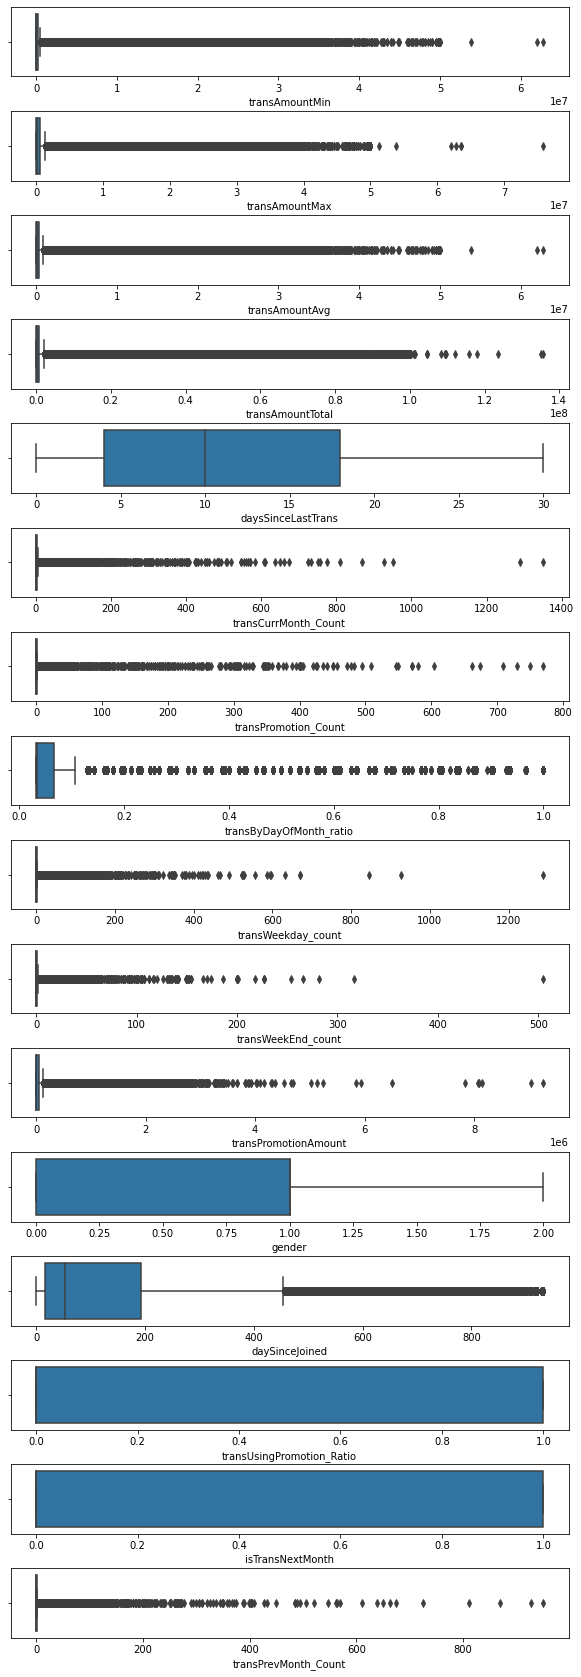

In [ ]:
from cProfile import label

numbercols = ['transAmountMin', 'transAmountMax', 'transAmountAvg',
       'transAmountTotal', 'daysSinceLastTrans', 'transCurrMonth_Count',
       'transPromotion_Count', 'transByDayOfMonth_ratio', 'transWeekday_count',
       'transWeekEnd_count', 'transPromotionAmount', 'gender',
       'daySinceJoined', 'transUsingPromotion_Ratio', 'isTransNextMonth',
       'transPrevMonth_Count']

numberOfChart = len(numbercols)

plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=0.5)
for i in range(numberOfChart):
    ax = plt.subplot(numberOfChart, 1, (i+1))
    sns.boxplot(cusFeatures[numbercols[i]])
    # ax.set_title(numbercols[i])
    
plt.show()

Xử lý các outliers bằng phương pháp IQR

In [ ]:
outlierNumCols = ['transAmountMin',
 'transAmountMax',
 'transAmountAvg',
 'transAmountTotal',
 'transCurrMonth_Count',
 'transPromotion_Count',
 'transByDayOfMonth_ratio',
 'transWeekday_count',
 'transWeekEnd_count',
 'transPromotionAmount',
 'daySinceJoined',
 'transPrevMonth_Count'
 ]

In [ ]:
# Remove outliers by using Interquantile Range:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    print('q1', quartile1)
    print('q3', quartile3)
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
# Show the min, max of each outlier number columns:
for numColName in outlierNumCols:
    print('min-max of', numColName, outlier_thresholds(cusFeatures, numColName) )
    print('=='*10)
    

q1 10000.0
q3 181000.0
min-max of transAmountMin (-246500.0, 437500.0)
q1 18122.0
q3 523369.0
min-max of transAmountMax (-739748.5, 1281239.5)
q1 13500.0
q3 372240.0
min-max of transAmountAvg (-524610.0, 910350.0)
q1 20000.0
q3 845898.0
min-max of transAmountTotal (-1218847.0, 2084745.0)
q1 1.0
q3 3.0
min-max of transCurrMonth_Count (-2.0, 6.0)
q1 0.0
q3 1.0
min-max of transPromotion_Count (-1.5, 2.5)
q1 0.032258064516129
q3 0.0666666666666666
min-max of transByDayOfMonth_ratio (-0.019354838709677406, 0.118279569892473)
q1 1.0
q3 2.0
min-max of transWeekday_count (-0.5, 3.5)
q1 0.0
q3 1.0
min-max of transWeekEnd_count (-1.5, 2.5)
q1 0.0
q3 50000.0
min-max of transPromotionAmount (-75000.0, 125000.0)
q1 17.0
q3 192.0
min-max of daySinceJoined (-245.5, 454.5)
q1 0.0
q3 1.0
min-max of transPrevMonth_Count (-1.5, 2.5)


In [ ]:
# Remove outliers:
for numColName in outlierNumCols:
    replace_with_thresholds(cusFeatures, numColName)


q1 10000.0
q3 181000.0
q1 18122.0
q3 523369.0
q1 13500.0
q3 372240.0
q1 20000.0
q3 845898.0
q1 1.0
q3 3.0
q1 0.0
q3 1.0
q1 0.032258064516129
q3 0.0666666666666666
q1 1.0
q3 2.0
q1 0.0
q3 1.0
q1 0.0
q3 50000.0
q1 17.0
q3 192.0
q1 0.0
q3 1.0


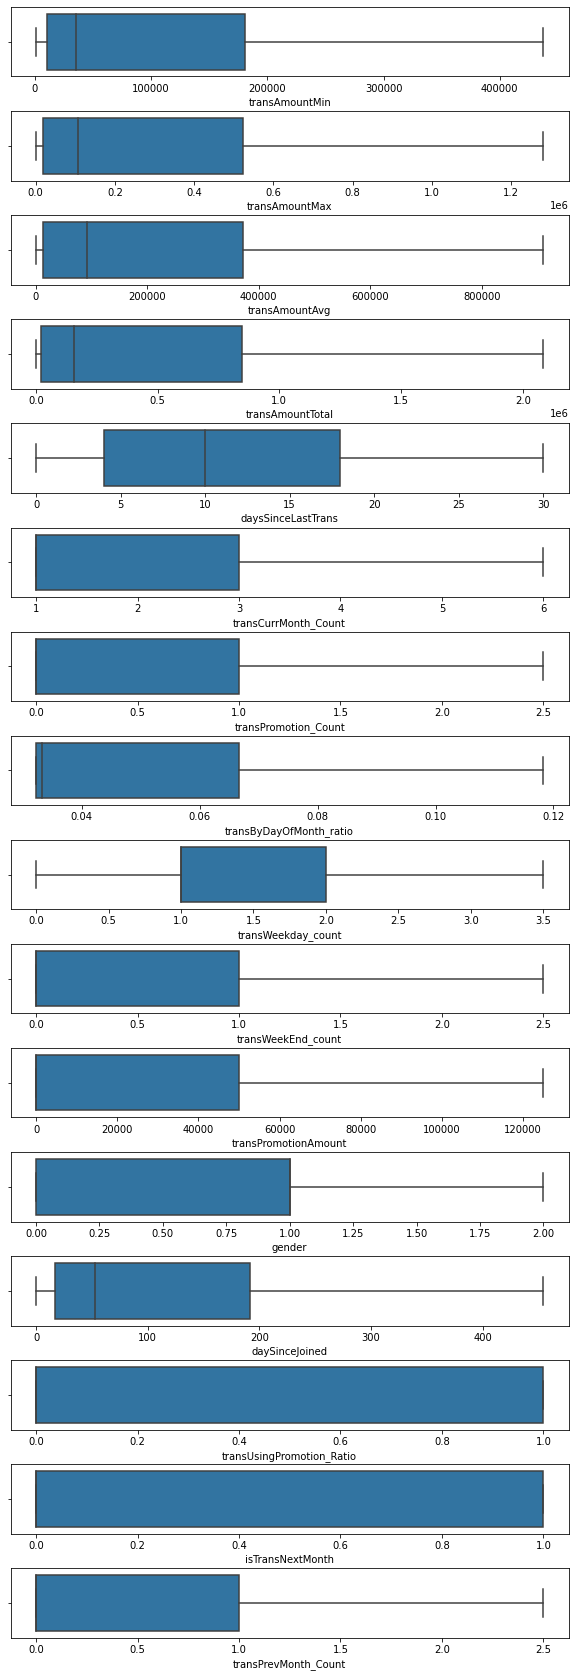

In [ ]:
numberOfChart = len(numbercols)

plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=0.5)
for i in range(numberOfChart):
    ax = plt.subplot(numberOfChart, 1, (i+1))
    sns.boxplot(cusFeatures[numbercols[i]])
    # ax.set_title(numbercols[i])
    
plt.show()

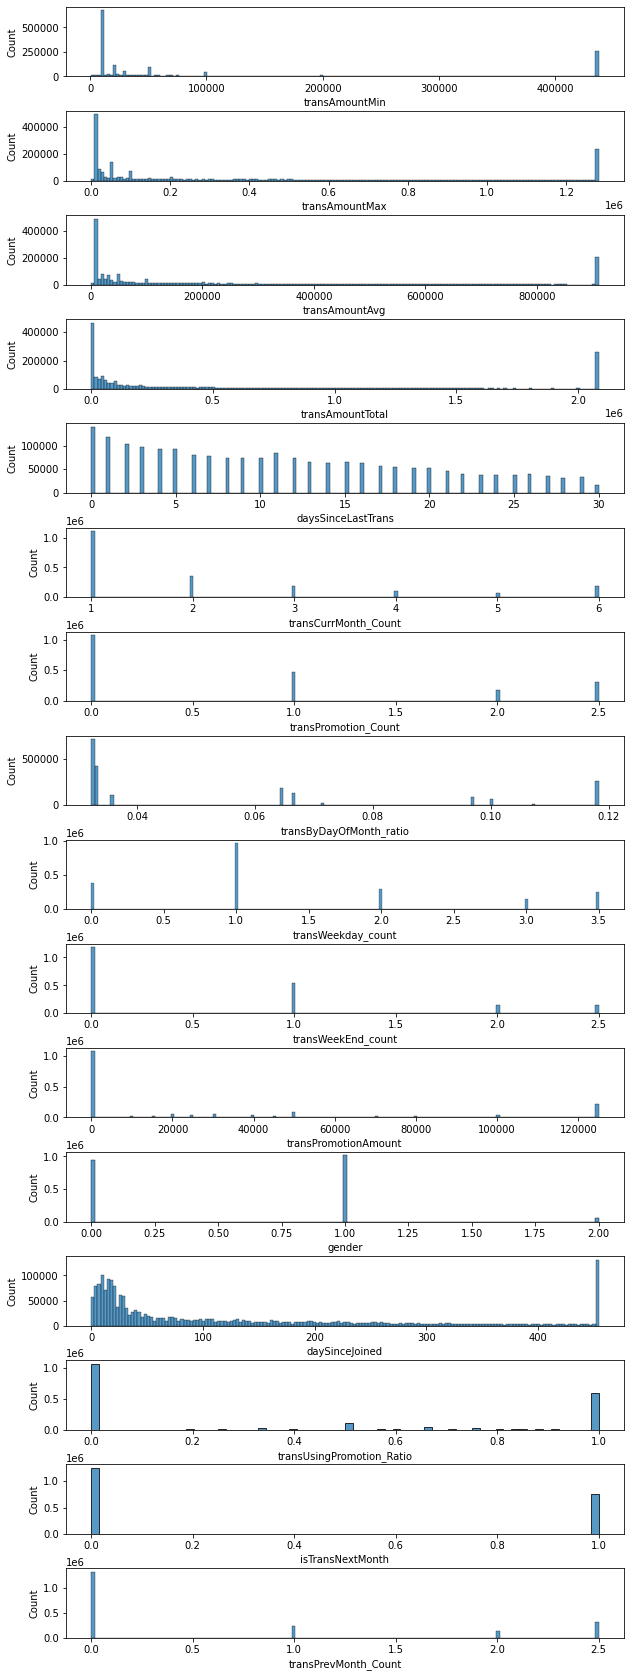

In [ ]:
numberOfChart = len(numbercols)

plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=0.5)
for i in range(numberOfChart):
    ax = plt.subplot(numberOfChart, 1, (i+1))
    sns.histplot(cusFeatures[numbercols[i]])
    # ax.set_title(numbercols[i])
    
plt.show()

## Deal with catigorical data

### AgeGroup

In [ ]:
cusFeatures.ageGroup.isna().sum()

0

In [ ]:
cusFeatures.ageGroup.value_counts()

25-35       720376
18-25       678485
35-45       229581
15-18       177339
Khong XD    129080
45-55        67397
55-65        23879
Name: ageGroup, dtype: int64

In [ ]:
cusFeatures.loc[cusFeatures['ageGroup'] == 'Khong XD', 'ageGroup'] = 0
cusFeatures.loc[cusFeatures['ageGroup'] == '15-18', 'ageGroup'] = 1
cusFeatures.loc[cusFeatures['ageGroup'] == '18-25', 'ageGroup'] = 2
cusFeatures.loc[cusFeatures['ageGroup'] == '25-35', 'ageGroup'] = 3
cusFeatures.loc[cusFeatures['ageGroup'] == '35-45', 'ageGroup'] = 4
cusFeatures.loc[cusFeatures['ageGroup'] == '45-55', 'ageGroup'] = 5
cusFeatures.loc[cusFeatures['ageGroup'] == '55-65', 'ageGroup'] = 6


### Gender

In [ ]:
cusFeatures.gender.value_counts()


1    1016283
0     952382
2      57472
Name: gender, dtype: int64

In [ ]:
# get dummies genders
getDummiesGender = pd.get_dummies(cusFeatures['gender'], prefix='gender')
cusFeatures = pd.concat([cusFeatures, getDummiesGender], axis=1)

### OS

In [ ]:
cusFeatures.os.value_counts()


iOS         1031384
Android      874239
KHONG XD     120514
Name: os, dtype: int64

In [ ]:
# get dummies genders
getDummiesOs = pd.get_dummies(cusFeatures['os'], prefix='os')
cusFeatures = pd.concat([cusFeatures, getDummiesOs], axis=1)

## Drop unusing columns

In [ ]:
# drop unusing Column usermapid:
cusFeatures.drop(columns=['USER_MAP_ID', 'gender', 'os'], inplace = True)

In [ ]:
cusFeatures.sample(5)


,transAmountMin,transAmountMax,transAmountAvg,transAmountTotal,daysSinceLastTrans,transCurrMonth_Count,transPromotion_Count,transByDayOfMonth_ratio,transWeekday_count,transWeekEnd_count,transPromotionAmount,ageGroup,daySinceJoined,transUsingPromotion_Ratio,isTransNextMonth,transPrevMonth_Count,gender_0,gender_1,gender_2,os_Android,os_KHONG XD,os_iOS
398226,10000,10000.0,10000.00,10000,6,1,0.0,0.032258,1.0,0.0,0,1,10.0,0.00,1.0,0.0,0,1,0,0,1,0
710136,10000,10000.0,10000.00,10000,2,1,0.0,0.032258,0.0,1.0,0,2,2.0,0.00,1.0,0.0,0,1,0,0,0,1
882405,437500,1281239.5,910350.00,2084745,13,1,1.0,0.032258,1.0,0.0,125000,3,267.0,1.00,0.0,1.0,0,1,0,0,0,1
1885202,10000,209000.0,89000.00,356000,1,4,2.5,0.118280,3.5,0.0,29000,3,132.0,0.75,1.0,0.0,0,1,0,0,0,1
31732,30000,338307.0,142076.75,568307,15,4,0.0,0.096774,3.5,0.0,0,3,46.0,0.00,1.0,2.0,1,0,0,1,0,0


In [ ]:
len(cusFeatures.columns)

22

## Xem Correlation between columns

Text(0.5, 0.98, 'Correlation Matrix across features')

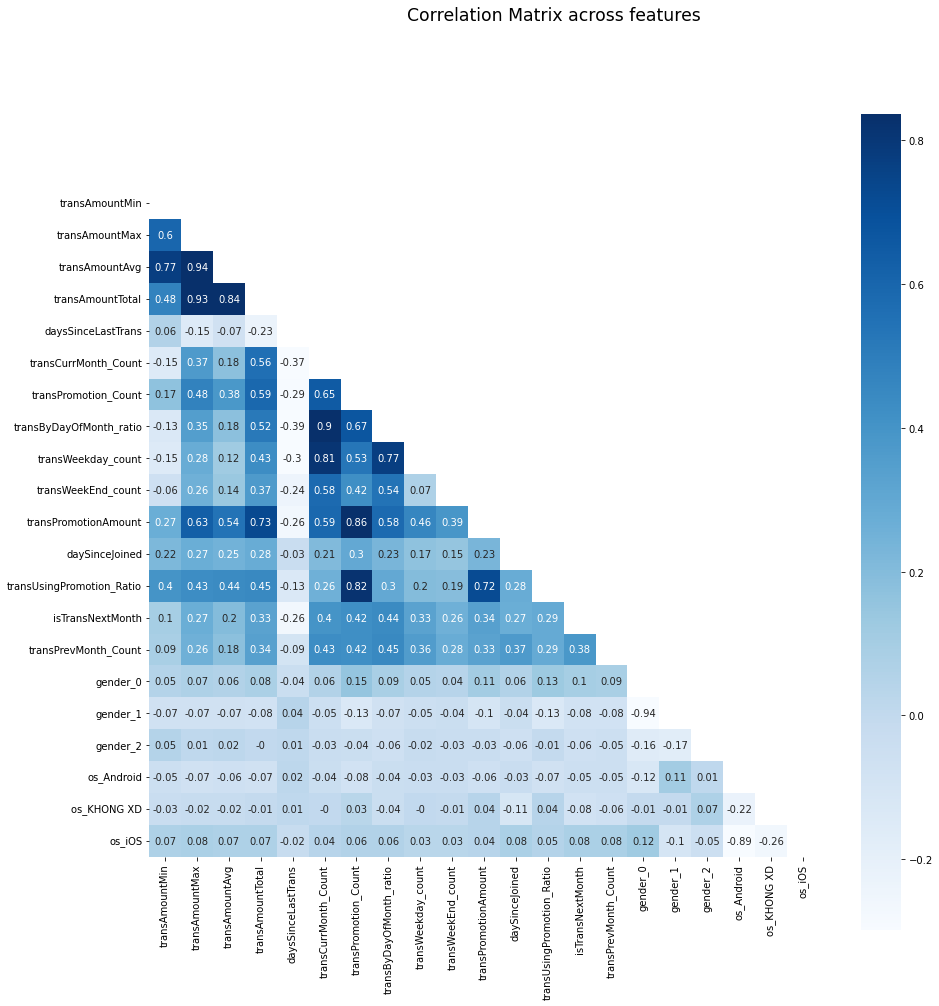

In [ ]:
features_subset = cusFeatures.copy()
plt.figure(figsize=(15, 15))
corr = round(features_subset.corr(), 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, annot=True, cmap=plt.cm.Blues, robust=True, square=True)
plt.suptitle("Correlation Matrix across features", size="xx-large")

gender_0 và gender_1 có high corr, 0.94, => ta drop bớt 1 column

In [ ]:
cusFeatures.drop(columns='gender_0', inplace = True)

In [ ]:
cusFeatures.head()

,transAmountMin,transAmountMax,transAmountAvg,transAmountTotal,daysSinceLastTrans,transCurrMonth_Count,transPromotion_Count,transByDayOfMonth_ratio,transWeekday_count,transWeekEnd_count,transPromotionAmount,ageGroup,daySinceJoined,transUsingPromotion_Ratio,isTransNextMonth,transPrevMonth_Count,gender_1,gender_2,os_Android,os_KHONG XD,os_iOS
0,10000,238000.0,35380.952381,743000,8,6,0.0,0.118280,3.5,0.0,0,4,19.0,0.000000,1.0,0.0,1,0,0,0,1
1,32000,170000.0,87100.000000,435500,0,5,0.0,0.096774,3.5,1.0,0,4,19.0,0.000000,1.0,0.0,1,0,0,0,1
2,10000,187000.0,35285.714286,247000,2,6,1.0,0.118280,3.5,2.0,47000,3,19.0,0.142857,1.0,0.0,1,0,0,0,1
3,5000,76799.0,14107.210526,268037,4,6,0.0,0.118280,3.5,1.0,0,3,19.0,0.000000,1.0,0.0,0,0,0,1,0
4,10000,270000.0,72083.333333,432500,2,6,1.0,0.118280,3.5,1.0,30000,3,19.0,0.166667,1.0,0.0,1,0,1,0,0


In [ ]:
# saving finished cusFeature dataset:
# cusFeatures.to_csv('./cusFeatures_finished.csv', index = False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load dataset:
cusFeatures = pd.read_csv('cusFeatures_finished.csv')
# cusFeatures = pd.read_csv('/content/drive/Othercomputers/My Laptop/Desktop/Project Customer Engagement/cusFeatures_finished.csv')

# Traning model

In [2]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



In [4]:
# Partition data
X_train, X_test, y_train, y_test = train_test_split(cusFeatures.drop(columns=['isTransNextMonth']), 
                                                    cusFeatures['isTransNextMonth'], 
                                                    test_size=.2, 
                                                    random_state=96)

In [5]:
# Evaluate function:
def evaluate(estimator, X, y,cross_val_score=None, on='train'):
    y_pred = estimator.predict(X)
    
    if not cross_val_score is None:
        print(f'mean accuracy on {on} set: ', cross_val_score.mean(), '\n')
    else:
        print(f'accuracy on {on} set: ', accuracy_score(y, y_pred), '\n')
    
    print(classification_report(y, y_pred))
    
    # Confusion_matrix:
    con_matrix = pd.crosstab(pd.Series(y, name='Actual' ),pd.Series(y_pred, name='Predicted'))
    plt.figure(figsize = (9,6))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')

    return y_pred

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1620909, 20), (405228, 20), (1620909,), (405228,))

In [7]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


In [8]:
rawModelResult = {}

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report


In [11]:
lr = LogisticRegression()

cvsLg = cross_val_score(lr, X_train, y_train,
                      scoring='accuracy',
                      cv = KFold(n_splits = 5, random_state= 96, shuffle=True),
                      n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished


In [12]:
# Mean score of accuracy:
cvsLg.mean()

0.6918877005391666

### Evaluate model

In [13]:
# fit model
lr.fit(X_train, y_train)


LogisticRegression()

mean accuracy on train set:  0.6918877005391666 

              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76   1006863
         1.0       0.60      0.57      0.58    614046

    accuracy                           0.69   1620909
   macro avg       0.67      0.67      0.67   1620909
weighted avg       0.69      0.69      0.69   1620909



array([0., 1., 0., ..., 1., 0., 0.])

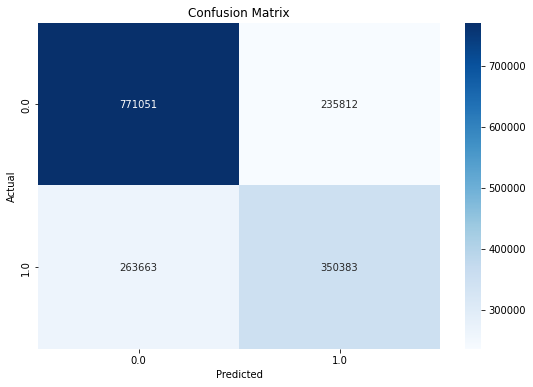

In [14]:
# Evaluate on Train set:
evaluate(lr, X_train, y_train, cvsLg, on='train')


mean accuracy on test set:  0.6918877005391666 

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76    251813
         1.0       0.60      0.57      0.58    153415

    accuracy                           0.69    405228
   macro avg       0.67      0.67      0.67    405228
weighted avg       0.69      0.69      0.69    405228



array([0., 0., 1., ..., 0., 0., 0.])

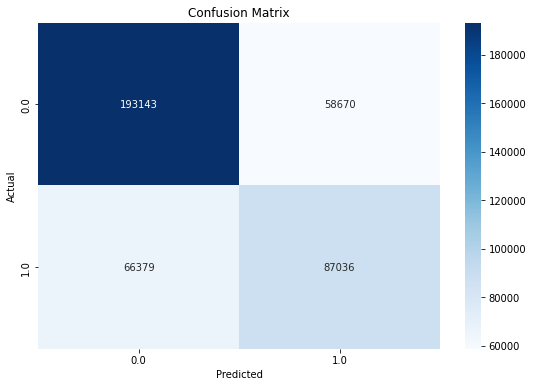

In [15]:
# Evaluate on Test set:
evaluate(lr, X_test, y_test, cvsLg, on='test')


In [5]:
rawModelResult['Logis.Regression'] = [0.6918877005391666, 0.69]


## DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier

decTree = DecisionTreeClassifier()
# param_grid1 = {'max_depth': np.arange(5,30), 
#               'min_samples_leaf': np.arange(1,300)
#              }
# decTreeRCV =  RandomizedSearchCV(decTree, param_grid1, n_iter=30,
#                                 scoring='accuracy',
#                                 n_jobs= -1,
#                                 cv=5,
#                                 verbose=1)
cvsDTree = cross_val_score(decTree, X_train, y_train,
                      scoring='accuracy',
                      cv = KFold(n_splits = 5, random_state= 96, shuffle=True),
                      n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.9s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.0s finished


In [17]:
cvsDTree

array([0.69901167, 0.6990857 , 0.69917515, 0.69943427, 0.69939941])

### Evaluate model

In [18]:
decTree.fit(X_train, y_train)

DecisionTreeClassifier()

mean accuracy on train set:  0.6992212395502586 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98   1006863
         1.0       1.00      0.95      0.97    614046

    accuracy                           0.98   1620909
   macro avg       0.98      0.97      0.98   1620909
weighted avg       0.98      0.98      0.98   1620909



array([0., 1., 1., ..., 1., 1., 0.])

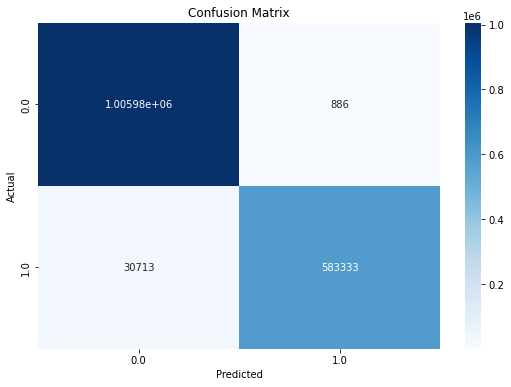

In [21]:
# Evaluate on Train set:
evaluate(decTree, X_train, y_train, cvsDTree , on='train')

accuracy on test set:  0.7010127631851698 

              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76    251813
         1.0       0.61      0.58      0.60    153415

    accuracy                           0.70    405228
   macro avg       0.68      0.68      0.68    405228
weighted avg       0.70      0.70      0.70    405228



array([0., 0., 0., ..., 0., 0., 0.])

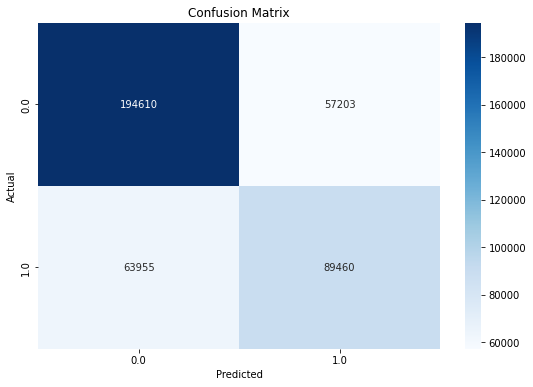

In [22]:
# Evaluate on Train set:
evaluate(decTree, X_test, y_test, on='test')

In [7]:
rawModelResult['DecisionTree'] = [0.98 , 0.7010127631851698 ]


## RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, random_state=42)

mean accuracy on train set:  0.6992212395502586 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98   1006863
         1.0       1.00      0.95      0.97    614046

    accuracy                           0.98   1620909
   macro avg       0.98      0.97      0.98   1620909
weighted avg       0.98      0.98      0.98   1620909



array([0., 1., 1., ..., 1., 1., 0.])

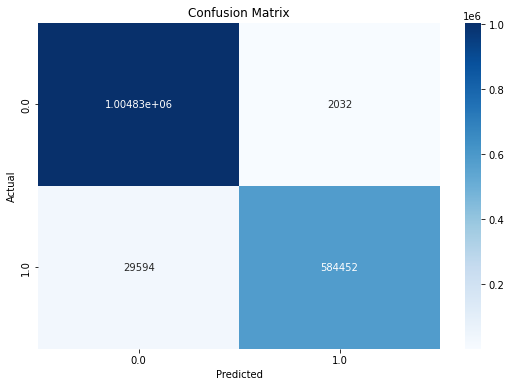

In [27]:
# Evaluate on Train set:
evaluate(rf, X_train, y_train, cvsDTree , on='train')

accuracy on test set:  0.757627804593957 

              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81    251813
         1.0       0.70      0.63      0.66    153415

    accuracy                           0.76    405228
   macro avg       0.74      0.73      0.74    405228
weighted avg       0.75      0.76      0.75    405228



array([0., 0., 1., ..., 0., 0., 0.])

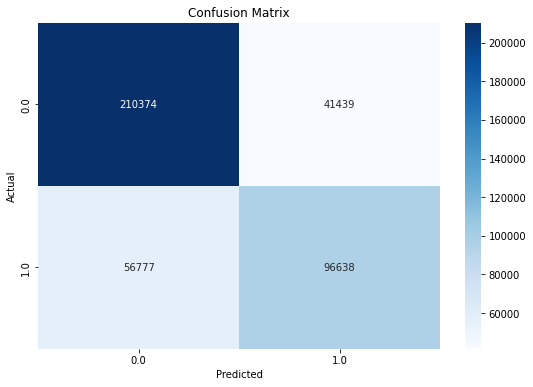

In [28]:
# Evaluate on Train set:
evaluate(rf, X_test, y_test, on='test')

In [8]:
rawModelResult['RandomForest'] = [0.98 , 0.757627804593957  ]


## XGBoost

In [11]:
from xgboost import XGBClassifier


In [13]:
xgb = XGBClassifier(learning_rate =0.1,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8)

In [12]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy on train set:  0.7667709908452602 

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82   1006863
         1.0       0.73      0.61      0.66    614046

    accuracy                           0.77   1620909
   macro avg       0.76      0.74      0.74   1620909
weighted avg       0.76      0.77      0.76   1620909



array([0, 1, 0, ..., 0, 0, 0])

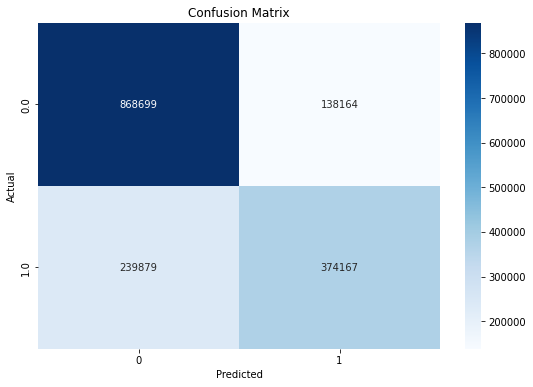

In [15]:
# Evaluate on Train set:
evaluate(xgb, X_train, y_train , on='train')

accuracy on test set:  0.7672816291075641 

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82    251813
         1.0       0.73      0.61      0.66    153415

    accuracy                           0.77    405228
   macro avg       0.76      0.74      0.74    405228
weighted avg       0.76      0.77      0.76    405228



array([0, 0, 1, ..., 0, 0, 0])

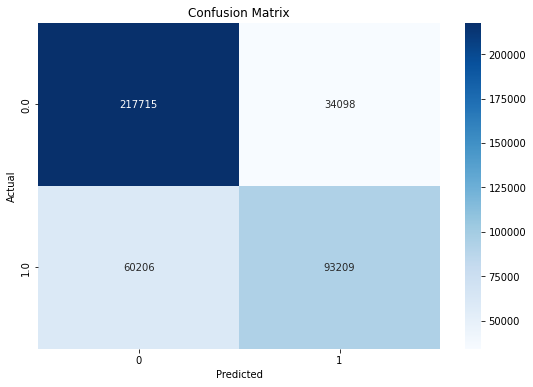

In [16]:
# Evaluate on Train set:
evaluate(xgb, X_test, y_test, on='test')

In [10]:
rawModelResult['XGBoost'] = [0.7667709908452602  , 0.7672816291075641  ]


## Adaboost

In [47]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
# param_grid2 = {'n_estimators':[50,60,70,80], 
#               'learning_rate': np.arange(1,10)
#              }
# ada_model =  RandomizedSearchCV(ada, param_grid2, n_iter=30,
#                                 scoring='accuracy',
#                                 n_jobs= -1,
#                                 cv=5,
#                                 verbose=1)

In [18]:
ada.fit(X_train, y_train)

AdaBoostClassifier()

accuracy on train set:  0.7575323475901485 

              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82   1006863
         1.0       0.73      0.58      0.64    614046

    accuracy                           0.76   1620909
   macro avg       0.75      0.72      0.73   1620909
weighted avg       0.75      0.76      0.75   1620909



array([0., 1., 0., ..., 0., 0., 0.])

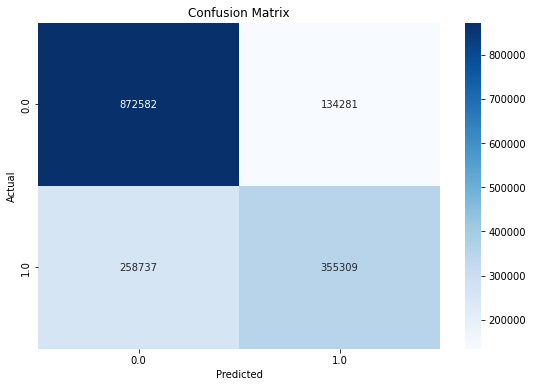

In [19]:
# Evaluate on Train set:
evaluate(ada, X_train, y_train , on='train')

accuracy on test set:  0.757778337133663 

              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82    251813
         1.0       0.73      0.58      0.64    153415

    accuracy                           0.76    405228
   macro avg       0.75      0.72      0.73    405228
weighted avg       0.75      0.76      0.75    405228



array([0., 0., 1., ..., 0., 0., 0.])

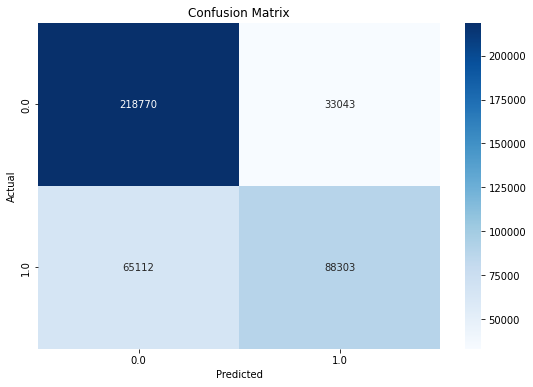

In [20]:
# Evaluate on Train set:
evaluate(ada, X_test, y_test, on='test')

In [ ]:
cusFeatures.sample(5)

,transAmountMin,transAmountMax,transAmountAvg,transAmountTotal,daysSinceLastTrans,transCurrMonth_Count,transPromotion_Count,transByDayOfMonth_ratio,transWeekday_count,transWeekEnd_count,transPromotionAmount,ageGroup,daySinceJoined,transUsingPromotion_Ratio,isTransNextMonth,transPrevMonth_Count,gender_1,gender_2,os_Android,os_KHONG XD,os_iOS
1944234,10000,1281239.5,910350.000000,2084745,1,5,2.5,0.100000,3.5,1.0,125000,0,27.0,0.8,0.0,0.0,0,0,0,0,1
1130250,42000,42000.0,42000.000000,42000,9,1,0.0,0.033333,1.0,0.0,0,2,9.0,0.0,0.0,0.0,1,0,0,0,1
959213,10000,10000.0,10000.000000,10000,19,1,0.0,0.032258,0.0,1.0,0,1,20.0,0.0,1.0,0.0,0,0,0,0,1
1093691,64840,1127000.0,515128.666667,1545386,16,3,0.0,0.033333,3.0,0.0,0,3,79.0,0.0,1.0,2.0,0,0,0,0,1
1459777,240801,240801.0,240801.000000,240801,2,1,0.0,0.033333,1.0,0.0,0,3,4.0,0.0,1.0,0.0,1,0,0,0,1


In [11]:
rawModelResult['Adaboost'] = [0.7575323475901485 , 0.757778337133663  ]


### Finetuning Adaboost

In [49]:
# Lay sample data de funtuning
X_train1 = X_train[int(X_train.shape[0]*0.3): int(X_train.shape[0]*0.3) + 500000]
y_train1 = y_train[int(X_train.shape[0]*0.3): int(X_train.shape[0]*0.3) + 500000]


In [56]:
param_grid2 = {'n_estimators':[50,60,70,80], 
              'learning_rate': np.arange(1,10)
             }
# ada_model =  RandomizedSearchCV(ada, param_grid2, n_iter=30,
#                                 scoring='accuracy',
#                                 n_jobs= -1,
#                                 cv=5,
#                                 verbose=1)
clf = RandomizedSearchCV(
    ada, 
    param_grid2, 
    n_iter=30,
    scoring='accuracy',
    n_jobs= 6,
    cv=5,
    verbose=1)
clf.fit(X_train1, y_train1)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
clf.best_score_

0.7533500000000001

In [53]:
adaBest1 = clf.best_estimator_
adaBest1.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1.04, n_estimators=20)

accuracy on train set:  0.7529589878272006 

              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81   1006863
         1.0       0.71      0.59      0.64    614046

    accuracy                           0.75   1620909
   macro avg       0.74      0.72      0.73   1620909
weighted avg       0.75      0.75      0.75   1620909



array([0., 1., 0., ..., 0., 0., 0.])

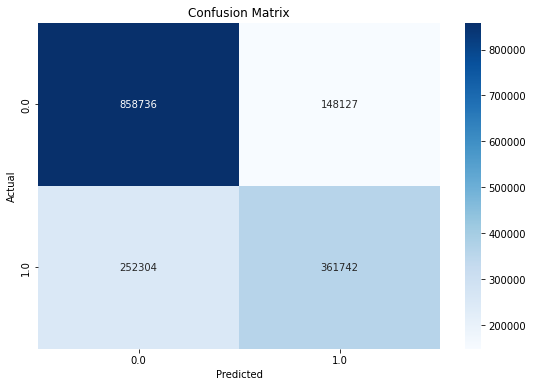

In [55]:
# Evaluate on Train set:
evaluate(adaBest1, X_train, y_train , on='train')

accuracy on test set:  0.7537509747598883 

              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81    251813
         1.0       0.71      0.59      0.64    153415

    accuracy                           0.75    405228
   macro avg       0.74      0.72      0.73    405228
weighted avg       0.75      0.75      0.75    405228



array([0., 0., 1., ..., 0., 0., 0.])

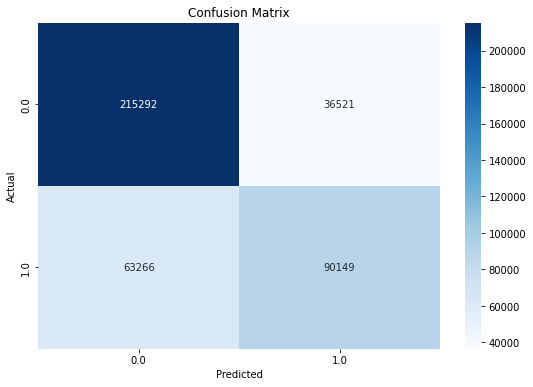

In [54]:
# Evaluate on Train set:
evaluate(adaBest1, X_test, y_test, on='test')

## Comparing raw model

In [ ]:
rawModelResult = {'Logis.Regression': [0.6918877005391666, 0.69],
 'DecisionTree': [0.98, 0.7010127631851698],
 'RandomForest': [0.98, 0.757627804593957],
 'XGBoost': [0.7667709908452602, 0.7672816291075641],
 'Adaboost': [0.7575323475901485, 0.757778337133663]}

In [ ]:
rawModelResult = {'Logis.Regression': [0.6918877005391666, 0.69],
 'DecisionTree': [0.98, 0.7010127631851698],
 'RandomForest': [0.98, 0.757627804593957],
 'Adaboost': [0.7575323475901485, 0.757778337133663]}

In [31]:
df1 = pd.DataFrame(rawModelResult).T.reset_index()
df1.columns = ['ModelName', 'Accuracy on trainset', 'Accuracy on testset']
df1

,ModelName,Accuracy on trainset,Accuracy on testset
0,Logis.Regression,0.691888,0.690000
1,DecisionTree,0.980000,0.701013
2,RandomForest,0.980000,0.757628
3,Adaboost,0.757532,0.757778


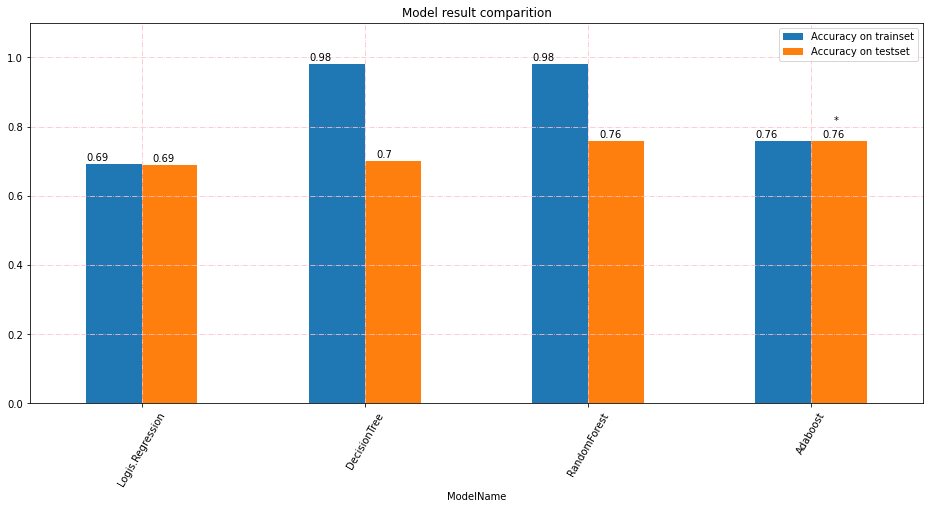

In [32]:
df1.plot(kind='bar', x = 'ModelName', figsize=(16,7))

for i in range(len(df1)):
    # train label:
    plt.text(i-0.25,df1['Accuracy on trainset'][i]+0.01 , round(df1['Accuracy on trainset'][i],2))

    # test label:
    plt.text(i+0.05,df1['Accuracy on testset'][i]+0.01 , round(df1['Accuracy on testset'][i],2))

plt.ylim(0,1.1)
plt.title('Model result comparition')
plt.grid(ls='-.', c='pink')
plt.xticks(rotation=60)

# Mark stars
i=3
plt.text(i+0.1,df1['Accuracy on testset'][i]+0.05 , '️*')
# i=4
# plt.text(i+0.1,df1['Accuracy on testset'][i]+0.05 , '️*')
# i=4
# plt.text(i+0.1,df1['Accuracy on testset'][i]+0.05 , '️*')

plt.show()

Choose XGBoost

## Finetuning XGBoost

In [48]:
# Lay sample data de funtuning
X_train1 = X_train[int(X_train.shape[0]*0.3): int(X_train.shape[0]*0.3) + 500000]
y_train1 = y_train[int(X_train.shape[0]*0.3): int(X_train.shape[0]*0.3) + 500000]


### Finding the best learnign rate

In [35]:
params = {'learning_rate': [0.1,0.12,0.15,0.2,0.23, 0.25]}

gsXgb = GridSearchCV(xgb, params,
                   scoring = 'accuracy', cv=5, n_jobs=6,
                   verbose=1)

In [36]:
gsXgb.fit(X_train1, y_train1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
              

In [38]:
gsXgb.best_score_

0.7673997282957226

In [39]:
pd.DataFrame(gsXgb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,97.735678,0.293229,0.345601,0.003060,0.1,{'learning_rate': 0.1},0.766274,0.767292,0.766447,0.766765,0.767002,0.766756,0.000368,5
1,94.709138,1.172155,0.362677,0.013178,0.12,{'learning_rate': 0.12},0.765791,0.767097,0.766015,0.766663,0.767814,0.766676,0.000734,6
2,97.640478,3.149599,0.373793,0.010145,0.15,{'learning_rate': 0.15},0.766418,0.767714,0.766745,0.766971,0.768061,0.767182,0.000612,4
3,102.574744,3.431171,0.417446,0.060320,0.2,{'learning_rate': 0.2},0.766614,0.767508,0.766786,0.767824,0.768267,0.767400,0.000623,1
4,109.376914,5.362573,0.479105,0.011321,0.23,{'learning_rate': 0.23},0.766408,0.767652,0.766560,0.767917,0.767989,0.767305,0.000682,2
5,120.105053,0.238141,0.466450,0.048311,0.25,{'learning_rate': 0.25},0.766356,0.767272,0.766549,0.767886,0.768297,0.767272,0.000747,3


Best learning rate so far = 0.2

In [45]:
# Get the best estimator with LR = 0.2
bestXGB1 = gsXgb.best_estimator_
bestXGB1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [46]:
bestXGB1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy on test set:  0.7686871995898598 

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82   1006863
         1.0       0.73      0.61      0.67    614046

    accuracy                           0.77   1620909
   macro avg       0.76      0.74      0.75   1620909
weighted avg       0.77      0.77      0.76   1620909



array([0, 1, 0, ..., 0, 0, 0])

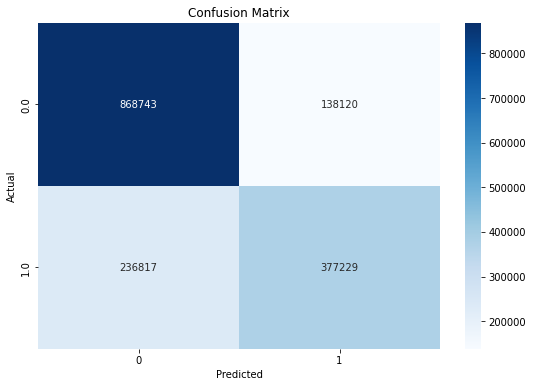

In [48]:
# Evaluate on Train set:
evaluate(bestXGB1, X_train, y_train, on='test')

accuracy on test set:  0.7689646322564088 

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82    251813
         1.0       0.73      0.61      0.67    153415

    accuracy                           0.77    405228
   macro avg       0.76      0.74      0.75    405228
weighted avg       0.77      0.77      0.76    405228



array([0, 0, 1, ..., 0, 0, 0])

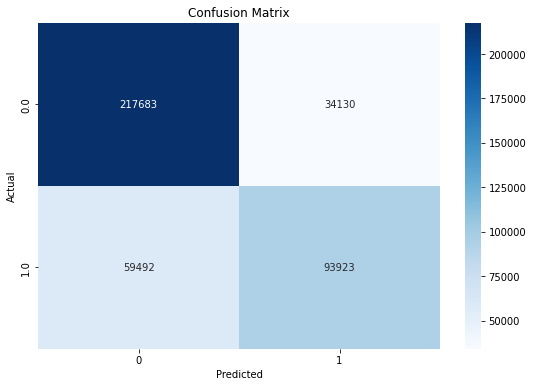

In [49]:
evaluate(bestXGB1, X_test, y_test, on='test')



### 2nd Finetune with LR = 0.2

In [59]:
params = {'learning_rate': [0.2],
         'n_estimators': range(60,170,20),
         'max_depth': range(1, 10, 2),
         'min_child_weight':range(1,6,2)}

rd_search = RandomizedSearchCV(bestXGB1, params,n_iter=10,
                           scoring = 'accuracy', cv=5, n_jobs=6,
                           verbose=1)

rd_search.fit(X_train1, y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.2, max_bin=256,
                                           max_cat_...
                                           max_leaves=0, min_child_weight=1,
                                           missing=nan,
    

In [61]:
rd_search.best_score_

0.7677225945527366

In [62]:
bestXGB2 = rd_search.best_estimator_

In [63]:
bestXGB2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy on test set:  0.7716219726091964 

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82   1006863
         1.0       0.74      0.62      0.67    614046

    accuracy                           0.77   1620909
   macro avg       0.76      0.74      0.75   1620909
weighted avg       0.77      0.77      0.77   1620909



array([0, 1, 0, ..., 0, 0, 0])

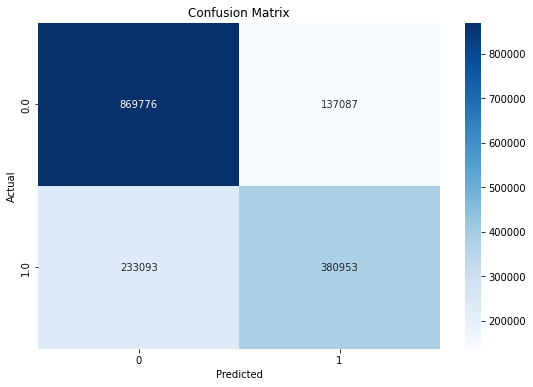

In [65]:
# Evaluate on Train set:
evaluate(bestXGB2, X_train, y_train, on='test')

accuracy on test set:  0.7696876819963082 

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82    251813
         1.0       0.73      0.62      0.67    153415

    accuracy                           0.77    405228
   macro avg       0.76      0.74      0.75    405228
weighted avg       0.77      0.77      0.77    405228



array([0, 0, 1, ..., 0, 0, 0])

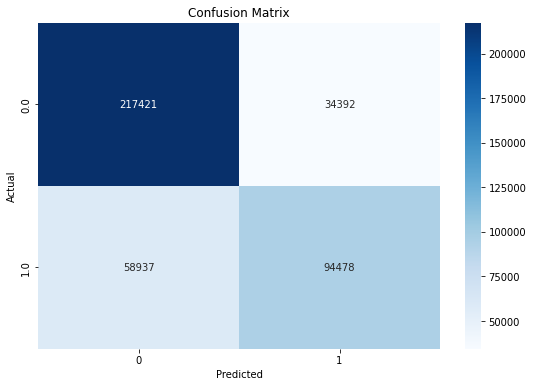

In [66]:
evaluate(bestXGB2, X_test, y_test, on='test')


In [68]:
bestXGB2.feature_importances_.shape

(20,)

In [25]:
Xcols = ['transAmountMin', 'transAmountMax', 'transAmountAvg',
       'transAmountTotal', 'daysSinceLastTrans', 'transCurrMonth_Count',
       'transPromotion_Count', 'transByDayOfMonth_ratio', 'transWeekday_count',
       'transWeekEnd_count', 'transPromotionAmount', 'ageGroup',
       'daySinceJoined', 'transUsingPromotion_Ratio',
       'transPrevMonth_Count', 'gender_1', 'gender_2', 'os_Android',
       'os_KHONG XD', 'os_iOS']

In [78]:
pd.DataFrame(index = [Xcols, bestXGB2.feature_importances_]).reset_index().style.background_gradient(cmap='Blues')

,level_0,level_1
0,transAmountMin,0.037693
1,transAmountMax,0.047275
2,transAmountAvg,0.008262
3,transAmountTotal,0.049054
4,daysSinceLastTrans,0.041915
5,transCurrMonth_Count,0.015600
6,transPromotion_Count,0.162197
7,transByDayOfMonth_ratio,0.347061
8,transWeekday_count,0.003416
9,transWeekEnd_count,0.005062


In [71]:
cusFeatures.head().columns

Index(['transAmountMin', 'transAmountMax', 'transAmountAvg',
       'transAmountTotal', 'daysSinceLastTrans', 'transCurrMonth_Count',
       'transPromotion_Count', 'transByDayOfMonth_ratio', 'transWeekday_count',
       'transWeekEnd_count', 'transPromotionAmount', 'ageGroup',
       'daySinceJoined', 'transUsingPromotion_Ratio', 'isTransNextMonth',
       'transPrevMonth_Count', 'gender_1', 'gender_2', 'os_Android',
       'os_KHONG XD', 'os_iOS'],
      dtype='object')

### 3rd fintuning with all dataset

In [17]:
# Define the search space
from sklearn.model_selection import StratifiedKFold

param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 0.2, 0.5, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['accuracy']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [18]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgb, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring='accuracy', 
                           n_jobs=6, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
random_result = random_search.fit(X_train1, y_train1)
# Print grid search summary
# random_result
# # Print the best score and the corresponding hyperparameters
# print(f'The best score is {random_result.best_score_:.4f}')
# print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
# print(f'The best hyperparameters are {random_result.best_params_}')

In [19]:
random_result.best_score_

0.7671700025541425

In [20]:
random_search.best_params_

{'reg_lambda': 100,
 'reg_alpha': 1,
 'max_depth': 18,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [21]:
bestXGB3 = random_search.best_estimator_

In [22]:
bestXGB3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=18, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=100, ...)

accuracy on train set:  0.7917131683518323 

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84   1006863
         1.0       0.77      0.65      0.70    614046

    accuracy                           0.79   1620909
   macro avg       0.78      0.76      0.77   1620909
weighted avg       0.79      0.79      0.79   1620909



array([0, 1, 0, ..., 0, 0, 0])

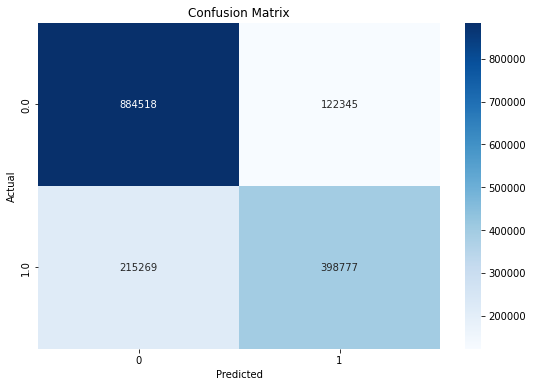

In [23]:
# Evaluate on Train set:
evaluate(bestXGB3, X_train, y_train, on='train')

accuracy on test set:  0.7716594114918022 

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82    251813
         1.0       0.74      0.62      0.67    153415

    accuracy                           0.77    405228
   macro avg       0.76      0.74      0.75    405228
weighted avg       0.77      0.77      0.77    405228



array([0, 0, 1, ..., 0, 0, 0])

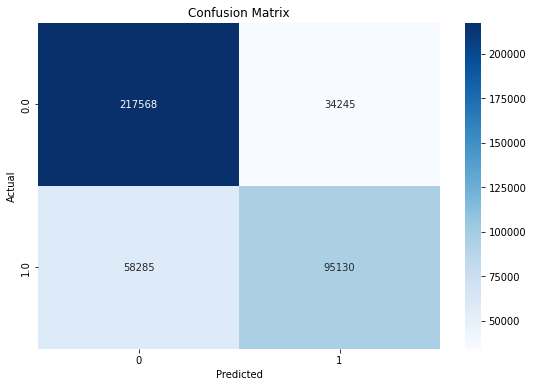

In [24]:
# Evaluate on Train set:
evaluate(bestXGB3, X_test, y_test, on='test')

In [26]:
# Feature importance
pd.DataFrame(index = [Xcols, bestXGB3.feature_importances_]).reset_index().style.background_gradient(cmap='Blues')


,level_0,level_1
0,transAmountMin,0.005298
1,transAmountMax,0.010176
2,transAmountAvg,0.005171
3,transAmountTotal,0.022552
4,daysSinceLastTrans,0.027741
5,transCurrMonth_Count,0.050760
6,transPromotion_Count,0.256767
7,transByDayOfMonth_ratio,0.102112
8,transWeekday_count,0.009256
9,transWeekEnd_count,0.003943


In [27]:
# save the model to disk
import pickle
filename = 'XGB3.model'
pickle.dump(bestXGB3, open(filename, 'wb'))